## A simple 1 -dimensional example to infer hyper parameters with selection effects:

In [503]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

### True value of hyper parameter

In [504]:
mu_lambda_T = 4.3 # in meters
sigma_lambda = 2 # in meters
x_max = 5 # in meters

### Generating true positions of speakers that will be playing:

In [505]:
N = 1000
x_T = np.random.normal(mu_lambda_T, sigma_lambda, N)

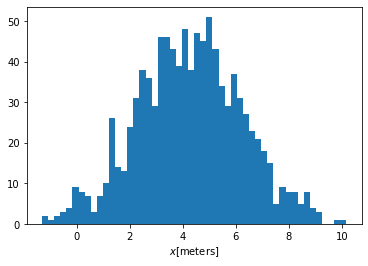

In [506]:
plt.hist(x_T, bins=50)
plt.xlabel('$x$[meters]')
plt.show()

### Generating noise (with zero mean and unit variance) and data:

In [507]:
noise = np.random.normal(0, 1, N)
data = x_T + noise

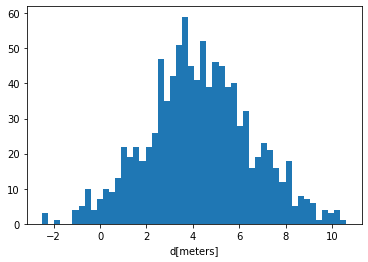

In [508]:
plt.hist(data, bins=50)
plt.xlabel('d[meters]')
plt.show()

#### Apply the selection effects i.e. only retain the data that satisfy the detection criteria: $d_i < x_{\mathrm{max}}$

In [509]:
selection_idx = data < x_max
xi = data[selection_idx]
N_tr = len(xi)
N_tr

635

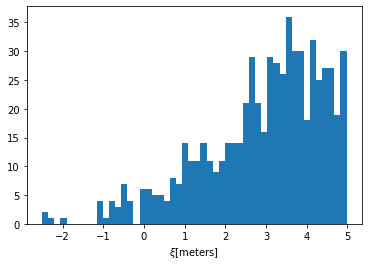

In [510]:
plt.hist(xi, bins=50)
plt.xlabel(r"$\xi$[meters]")
plt.show()

### Estimating selection effects:

$$ \alpha(\mu_\lambda) = \int dx \pi(x|\mu_\lambda) p(\rho_{\uparrow}|x)$$

In [511]:
def pop_prior_x(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2*sigma**2)) / (np.sqrt(2 * np.pi * sigma**2))

In [575]:
x = np.linspace(-5, 10, 1000)
mu_lambda = np.linspace(0, 10, 100)
sig_lambda = 2

In [576]:
def selection_function(x, mu_lamb, sig_lamb, x_max):
    
    detectability_function = (1/2) * ( 1 + erf((x_max - x) / np.sqrt(2)))
    
    alpha_lambda = []
    for mu in mu_lamb:
        prior_function = pop_prior_x(x, mu, sig_lamb)
        alpha_lambda.append(np.trapz(detectability_function * prior_function, x))
        
    return np.array(alpha_lambda)

In [577]:
alpha_mu_lambda = selection_function(x, mu_lambda, sig_lambda, x_max)
#alpha_mu_lambda

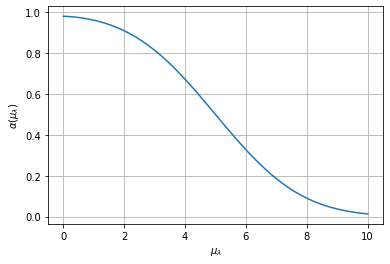

In [578]:
plt.plot(mu_lambda, alpha_mu_lambda)
plt.xlabel(r"$\mu_\lambda$")
plt.ylabel(r"$\alpha(\mu_\lambda)$")
plt.grid()

### Hyper-posterior from analytical integration on likelihood:

In [516]:
def hyper_posterior(mu_lambda, sig_lambda, data, selection_function):
    
    N_trigger = len(data)
    log_posterior = []
    
    for mu, alpha_lambda in zip(mu_lambda, selection_function):
        exponent_argument = 0.0
        for d in data:
            exponent_argument += -(d - mu)**2 / (2 * (1 + sig_lambda**2)) 
            
        log_posterior.append(exponent_argument - N_trigger*np.log(alpha_lambda))
    
    log_posterior = np.array(log_posterior)
    
    return np.exp(log_posterior)

### Estimating hyper posterior using detected data and selection effects:

In [517]:
mu_lambda_posterior = hyper_posterior(mu_lambda, sig_lambda, xi, alpha_mu_lambda)

Text(0.5, 1.0, '$x_{max} = 5, \\mu_\\lambda^T = 4.3, \\sigma_\\lambda = 2$')

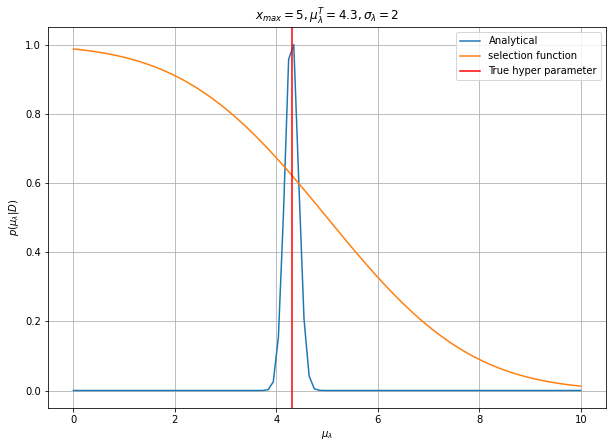

In [518]:
plt.figure(figsize=(10,7))
plt.plot(mu_lambda, mu_lambda_posterior/max(mu_lambda_posterior), label="Analytical")
plt.plot(mu_lambda, alpha_mu_lambda, label="selection function")
plt.axvline(x=mu_lambda_T, c='r', label="True hyper parameter")
plt.xlabel("$\mu_\lambda$")
plt.ylabel("$ p(\mu_\lambda|D)$")
plt.legend(loc='best')
plt.grid()
plt.title("$x_{max} = 5, \mu_\lambda^T = 4.3, \sigma_\lambda = 2$")

## Estimating hyper posterior numerically: drawing samples for individual detected events likelihoods:

In [519]:
def sample_likelihood(mean, sigma, Nsamples):
    samples = np.random.normal(mean, sigma, Nsamples)
    return samples

In [559]:
likelihood_samples = []
for d in xi:
    x_samples = sample_likelihood(d, 1, 2000)
    likelihood_samples.append(x_samples)

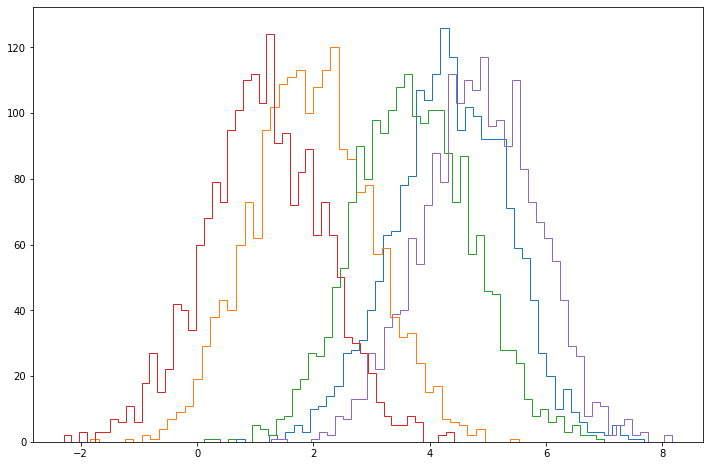

In [560]:
plt.figure(figsize=(12, 8))
for pos_sample in likelihood_samples[0:5]:
    plt.hist(pos_sample, bins=50, histtype=u'step')

In [563]:
def hyper_pos_numerical(mu_lambda, sig_lambda, posterior_samples, selection_function, sampling_prior):
    
    N_trigger = len(posterior_samples)
    
    posterior = []
    
    for mu, alpha_lambda in zip(mu_lambda, selection_function):
        pop_prior_term = 0.0
        for pos_sample in posterior_samples:
            pop_prior = prior_x(pos_sample, mu, sig_lambda)
            pop_prior_term += np.log(sum(pop_prior)/len(pos_sample)/sampling_prior)
        posterior.append(pop_prior_term - N_trigger*np.log(alpha_lambda))
    posterior = np.array(posterior)
    
    return np.exp(posterior)

In [579]:
sampling_prior = 1/15
mu_lambda_num_posterior = hyper_pos_numerical(mu_lambda, sig_lambda, likelihood_samples, alpha_mu_lambda, sampling_prior)

Text(0.5, 1.0, '$x_{max} = 5, \\mu_\\lambda^T = 4.3, \\sigma_\\lambda = 2$')

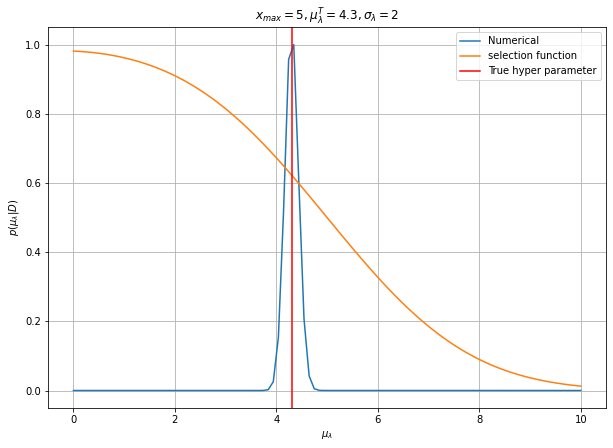

In [580]:
plt.figure(figsize=(10,7))
plt.plot(mu_lambda, mu_lambda_num_posterior/max(mu_lambda_num_posterior), label="Numerical")
plt.plot(mu_lambda, alpha_mu_lambda, label="selection function")
plt.axvline(x=mu_lambda_T, c='r', label="True hyper parameter")
plt.xlabel("$\mu_\lambda$")
plt.ylabel("$ p(\mu_\lambda|D)$")
plt.legend(loc='best')
plt.grid()
plt.title("$x_{max} = 5, \mu_\lambda^T = 4.3, \sigma_\lambda = 2$")

Text(0.5, 1.0, '$x_{max} = 5, \\mu_\\lambda^T = 4.3, \\sigma_\\lambda = 2$')

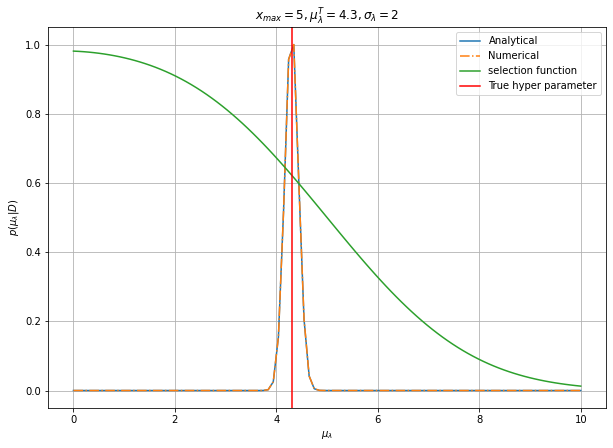

In [581]:
plt.figure(figsize=(10,7))
plt.plot(mu_lambda, mu_lambda_posterior/max(mu_lambda_posterior), label="Analytical")
plt.plot(mu_lambda,mu_lambda_num_posterior/max(mu_lambda_num_posterior), label="Numerical", ls='-.')
plt.plot(mu_lambda, alpha_mu_lambda, label="selection function")
plt.axvline(x=mu_lambda_T, c='r', label="True hyper parameter")
plt.xlabel("$\mu_\lambda$")
plt.ylabel("$ p(\mu_\lambda|D)$")
plt.legend(loc='best')
plt.grid()
plt.title("$x_{max} = 5, \mu_\lambda^T = 4.3, \sigma_\lambda = 2$")

### Changing the true value of mean $\mu_{\lambda}$:

In [541]:
#choosing a new value of mean of distribution of speakers
mu1_lambda_T = 8.3

# Generating the true positions of speakers that play
N = 1000
x1_T = np.random.normal(mu1_lambda_T, sigma_lambda, N)

# Generating noise and adding it to true positions to get 
# the data
noise1 = np.random.normal(0, 1, N)
data1 = x1_T + noise1

# Applying the detection criteria and collect the detected events
selection_idx = data1 < x_max
xi1 = data1[selection_idx]

In [582]:
# Analytical case
mu1_lambda_posterior = hyper_posterior(mu_lambda, sig_lambda, xi1, alpha_mu_lambda)

# Numerical case
# Drawing samples from the likelihood
likelihood_samples1 = []
for d in xi1:
    x_samples = sample_likelihood(d, 1, 10000)
    likelihood_samples1.append(x_samples)
mu1_lambda_num_posterior = hyper_pos_numerical(mu_lambda, sig_lambda, likelihood_samples1, alpha_mu_lambda, sampling_prior)

Text(0.5, 1.0, '$x_{max} = 5, \\mu_\\lambda^T = 8.3, \\sigma_\\lambda = 2$')

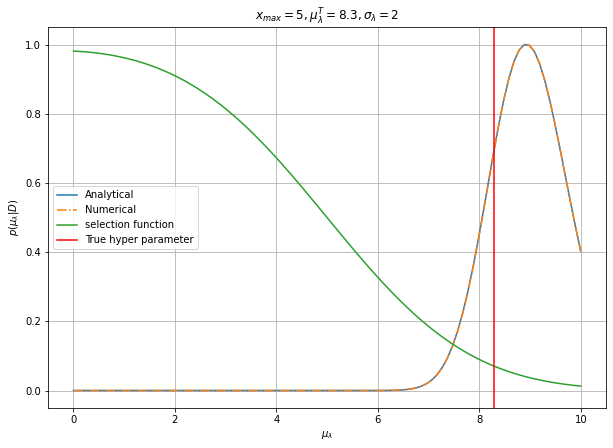

In [583]:
plt.figure(figsize=(10,7))
plt.plot(mu_lambda, mu1_lambda_posterior/max(mu1_lambda_posterior), label="Analytical")
plt.plot(mu_lambda,mu1_lambda_num_posterior/max(mu1_lambda_num_posterior), label="Numerical", ls='-.')
plt.plot(mu_lambda, alpha_mu_lambda, label="selection function")
plt.axvline(x=mu1_lambda_T, c='r', label="True hyper parameter")
plt.xlabel("$\mu_\lambda$")
plt.ylabel("$ p(\mu_\lambda|D)$")
plt.legend(loc='best')
plt.grid()
plt.title("$x_{max} = 5, \mu_\lambda^T = 8.3, \sigma_\lambda = 2$")

In the second case, for $\mu_\lambda^T = 8.3$, the sound from most of the speakers is not detected by the detector because large number of speakers that will be playing will be outside the detection threhold i.e. $d>x_{\max}$. But we do recover the right posterior distribution of hyper parameter $\mu_\lambda$. Can you think why? (Hint: selection effects might provide an answer).